In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
import seaborn as sb

In [18]:
df_path = "Call Center_Call Center.csv"
df = pd.read_csv(df_path, encoding='utf-16', sep='\t')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32941 entries, 0 to 32940
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Call Center                    32941 non-null  object 
 1   Call Timestamp                 32941 non-null  object 
 2   Channel                        32941 non-null  object 
 3   City                           32941 non-null  object 
 4   Customer Name                  32941 non-null  object 
 5   Id                             32941 non-null  object 
 6   Reason                         32941 non-null  object 
 7   Response Time                  32941 non-null  object 
 8   Sentiment                      32941 non-null  object 
 9   State                          32941 non-null  object 
 10  Average Call Duration          32941 non-null  int64  
 11  Average Customer Satisfaction  12271 non-null  float64
 12  Call Duration                  32941 non-null 

In [19]:
df.describe()

,Average Call Duration,Average Customer Satisfaction,Call Duration,Csat Score,sat rate,Total Calls Received
count,32941.000000,12271.000000,32941.000000,12271.000000,12271.000000,32941.0
mean,25.021159,5.548448,25.021159,5.548448,0.001684,1.0
std,11.816218,2.371059,11.816218,2.371059,0.000720,0.0
min,5.000000,1.000000,5.000000,1.000000,0.000304,1.0
25%,15.000000,4.000000,15.000000,4.000000,0.001214,1.0
50%,25.000000,5.000000,25.000000,5.000000,0.001518,1.0
75%,35.000000,7.000000,35.000000,7.000000,0.002125,1.0
max,45.000000,10.000000,45.000000,10.000000,0.003036,1.0


In [23]:
df['Call Timestamp'] = pd.to_datetime(df['Call Timestamp'], format='%d/%m/%Y %H:%M:%S')

In [59]:
call_count = df['Call Timestamp'].value_counts()

print(call_count.to_string())

Call Timestamp
2020-10-21    1170
2020-10-22    1167
2020-10-06    1152
2020-10-28    1144
2020-10-16    1132
2020-10-09    1123
2020-10-17    1123
2020-10-30    1120
2020-10-13    1117
2020-10-23    1111
2020-10-15    1105
2020-10-19    1102
2020-10-24    1098
2020-10-18    1097
2020-10-10    1092
2020-10-14    1090
2020-10-05    1090
2020-10-01    1089
2020-10-03    1089
2020-10-12    1088
2020-10-11    1087
2020-10-02    1084
2020-10-20    1077
2020-10-08    1067
2020-10-25    1063
2020-10-27    1062
2020-10-26    1054
2020-10-29    1053
2020-10-04    1049
2020-10-07    1045
2020-10-31       1


In [60]:
df = df[df["Call Date"] != pd.to_datetime("2020-10-31").date()]

In [61]:
call_count = df['Call Timestamp'].value_counts()

print(call_count.to_string())

Call Timestamp
2020-10-21    1170
2020-10-22    1167
2020-10-06    1152
2020-10-28    1144
2020-10-16    1132
2020-10-17    1123
2020-10-09    1123
2020-10-30    1120
2020-10-13    1117
2020-10-23    1111
2020-10-15    1105
2020-10-19    1102
2020-10-24    1098
2020-10-18    1097
2020-10-10    1092
2020-10-05    1090
2020-10-14    1090
2020-10-03    1089
2020-10-01    1089
2020-10-12    1088
2020-10-11    1087
2020-10-02    1084
2020-10-20    1077
2020-10-08    1067
2020-10-25    1063
2020-10-27    1062
2020-10-26    1054
2020-10-29    1053
2020-10-04    1049
2020-10-07    1045


## Dropped 2020-10-31 because there was only one call and it was skewing the results.

<Axes: xlabel='Hour', ylabel='Day'>

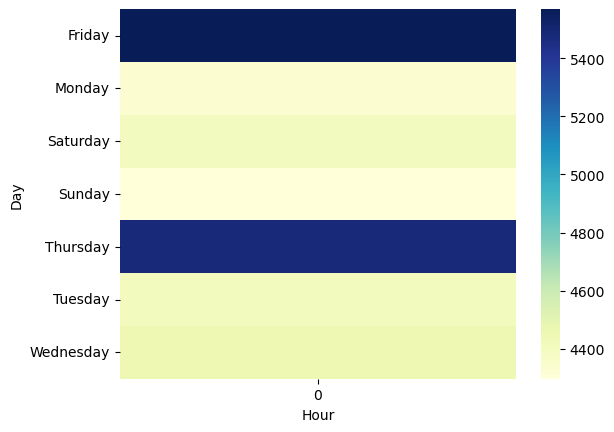

In [76]:
df = df.copy()

df.loc[:, 'Call Timestamp'] = pd.to_datetime(df['Call Timestamp'], errors='coerce')

df.loc[:, 'Hour'] = df['Call Timestamp'].dt.hour
df.loc[:, 'Day'] = df['Call Timestamp'].dt.day_name()

df['Call Timestamp'] = pd.to_datetime(df['Call Timestamp'])
df['Hour'] = df['Call Timestamp'].dt.hour
df['Day'] = df['Call Timestamp'].dt.day_name()

heat_data = df.groupby(['Day', 'Hour']).size().unstack().fillna(0)
sb.heatmap(heat_data, cmap='YlGnBu')

## This is a heat map of the call volumns per day, there are no hours on the time stamps so it's not broken down by that. Shows Friday and Thursdays to be busy

<Axes: xlabel='Hour', ylabel='Day'>

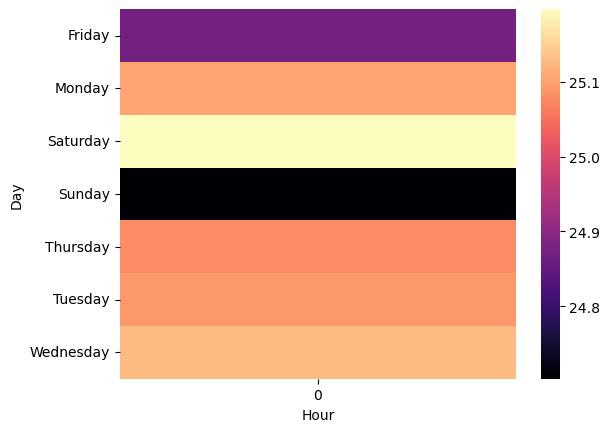

In [70]:
heat_data = df.groupby(['Day', 'Hour'])['Call Duration'].mean().unstack()
sb.heatmap(heat_data, cmap='magma')

## Same as above about the time stamps, but this is about call duration and what days had the longer calls.

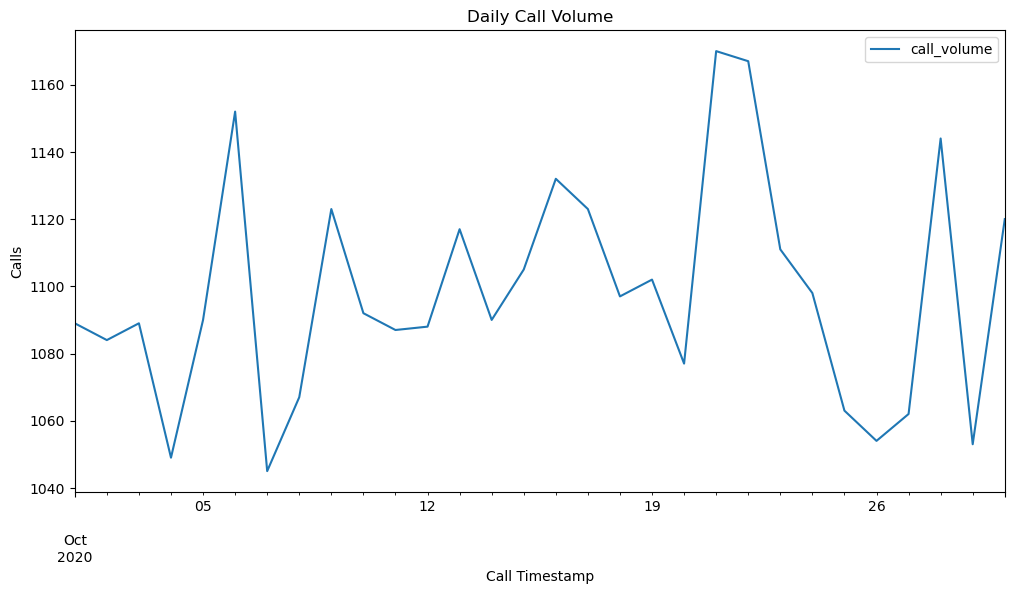

In [77]:
df['Call Timestamp'] = pd.to_datetime(df['Call Timestamp']) 

daily_calls = df.groupby(df['Call Timestamp'].dt.date).size().reset_index(name='call_volume')
daily_calls['Call Timestamp'] = pd.to_datetime(daily_calls['Call Timestamp'])
daily_calls.set_index('Call Timestamp', inplace=True)

daily_calls['call_volume'].plot(figsize=(12, 6), title='Daily Call Volume')
plt.xlabel('Call Timestamp')
plt.ylabel('Calls')
plt.legend()
plt.show()

## shows the call volume

14:20:14 - cmdstanpy - INFO - Chain [1] start processing
14:20:14 - cmdstanpy - INFO - Chain [1] done processing


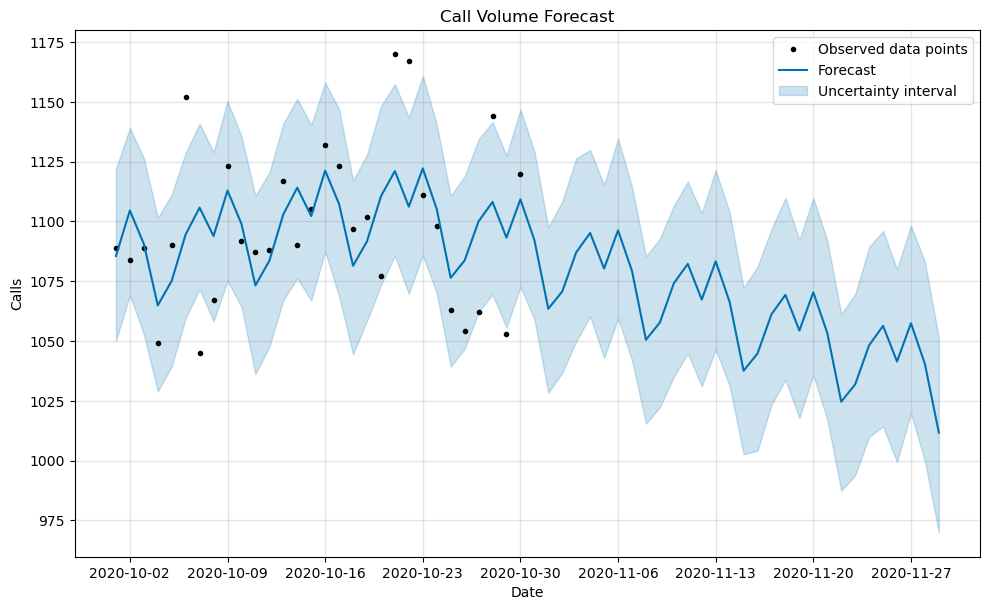

In [78]:
call_data = daily_calls.reset_index().rename(columns={'Call Timestamp': 'ds', 'call_volume': 'y'})

model = Prophet()
model.fit(call_data)

future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

model.plot(forecast)
plt.title("Call Volume Forecast")
plt.xlabel("Date")
plt.ylabel("Calls")
plt.legend()
plt.show()

## This shows the forecast trend

C:\Users\bowli\AppData\Local\Temp\ipykernel_2900\4064239969.py:2: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


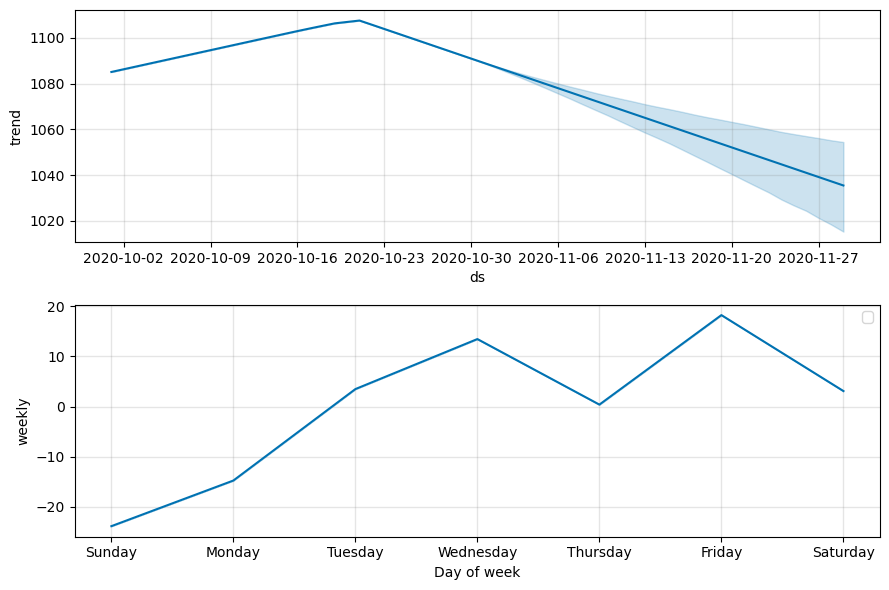

In [73]:
model.plot_components(forecast)
plt.legend()
plt.show()

## First Graph: There is a steady increase in calls around mid to late october, after that it starts to go down, the blue shade shows an increase of uncertainty as time goes on.

## Second Graph: peaks on Wednesday and Friday and goes down. 

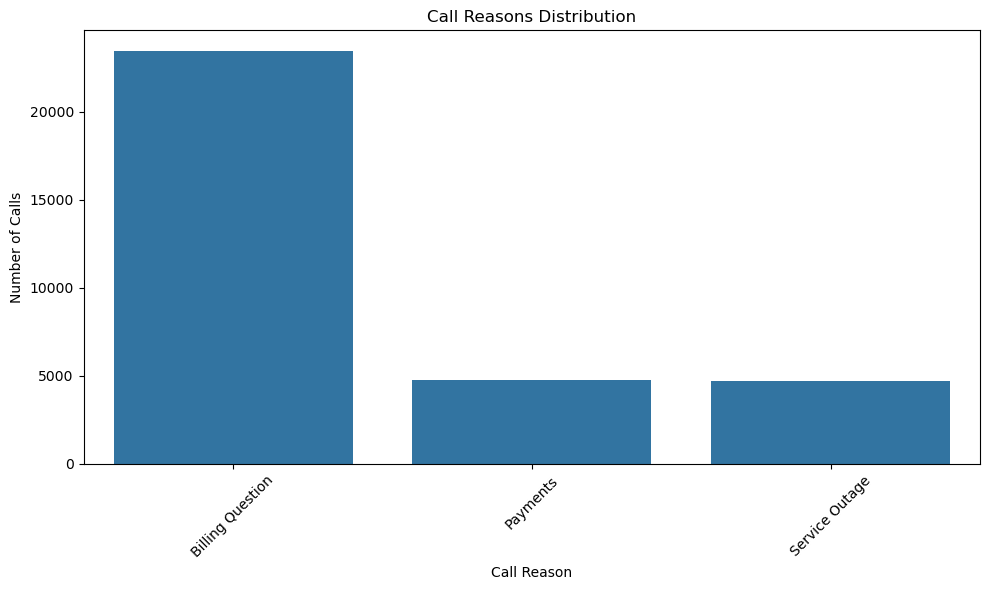

In [74]:
plt.figure(figsize=(10, 6))
sb.countplot(data=df, x='Reason', order=df['Reason'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Call Reasons Distribution')
plt.xlabel('Call Reason')
plt.ylabel('Number of Calls')
plt.tight_layout()
plt.show()

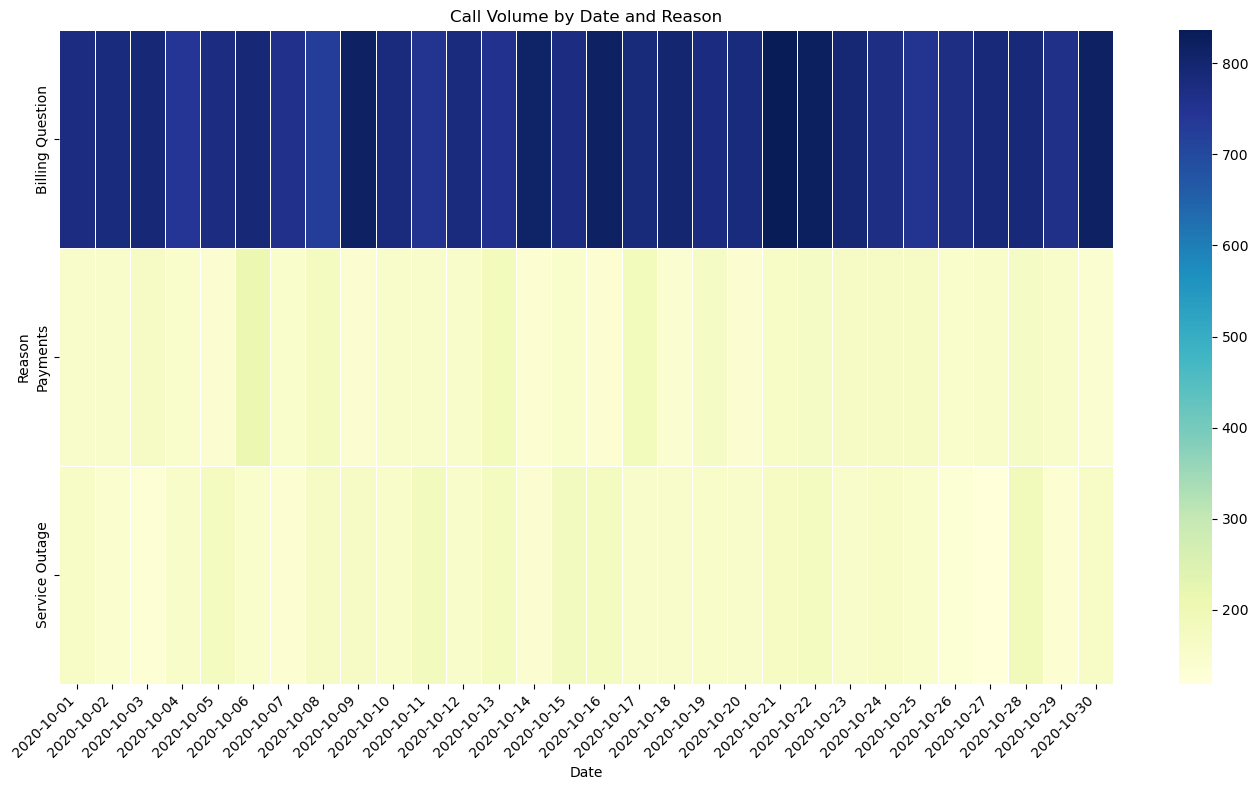

In [75]:
df["Call Timestamp"] = pd.to_datetime(df["Call Timestamp"], errors='coerce')

df["Call Date"] = df["Call Timestamp"].dt.date

heatmap_data = df.groupby(["Call Date", "Reason"]).size().unstack(fill_value=0)

plt.figure(figsize=(14, 8))
sb.heatmap(heatmap_data.T, cmap="YlGnBu", linewidths=0.5)
plt.title("Call Volume by Date and Reason")
plt.xlabel("Date")
plt.ylabel("Reason")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Heatmap to show the types of calls are popular on what day

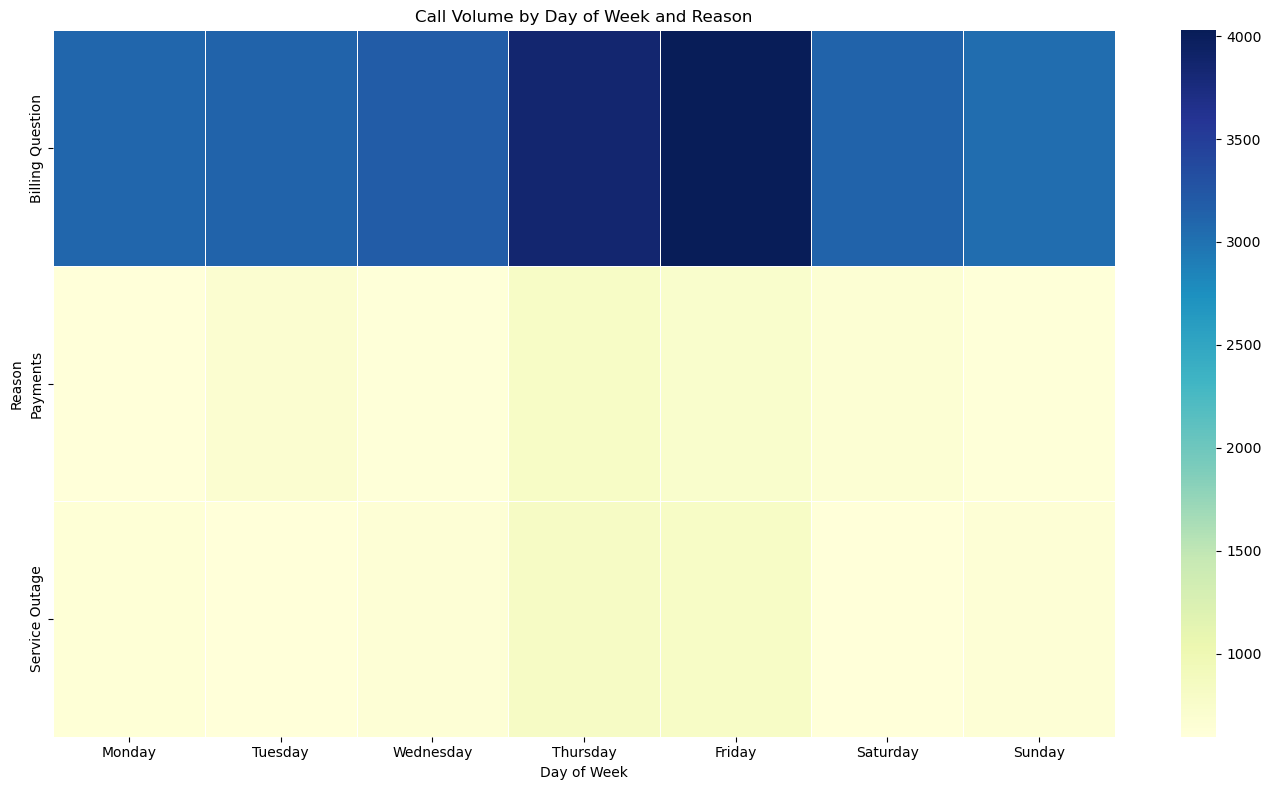

In [81]:
df["Call Timestamp"] = pd.to_datetime(df["Call Timestamp"], errors='coerce')
df["Day of Week"] = df["Call Timestamp"].dt.day_name()

heatmap_data = df.groupby(["Day of Week", "Reason"]).size().unstack(fill_value=0)

ordered_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
heatmap_data = heatmap_data.reindex(ordered_days)

plt.figure(figsize=(14, 8))
sb.heatmap(heatmap_data.T, cmap="YlGnBu", linewidths=0.5)
plt.title("Call Volume by Day of Week and Reason")
plt.xlabel("Day of Week")
plt.ylabel("Reason")
plt.tight_layout()
plt.show()